In [8]:
!pip install scipy


[notice] A new release of pip is available: 23.1 -> 24.2
[notice] To update, run: C:\Users\xhex8\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import sympy as sp
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
def fourpanel_evaluate(F_obs):
    initial_guess = [0.5, 0.5]
    F00_obs = F_obs[0][0]
    F01_obs = F_obs[0][1]
    F10_obs = F_obs[1][0]
    F11_obs = F_obs[1][1]
    F_sum = F00_obs + F10_obs + F01_obs + F11_obs

    #define error function (sum of squared error)
    def error_function(vars):
        x, y = vars

        F00_pred = 1 / np.sqrt(x**2 + y**2)
        F01_pred = 1 / np.sqrt(x**2 + (1 - y)**2)
        F10_pred = 1 / np.sqrt((1 - x)**2 + y**2)
        F11_pred = 1 / np.sqrt((1 - x)**2 + (1 - y)**2)

        F_pred_sum = F00_pred + F10_pred + F01_pred + F11_pred
        F00_pred_scaled = F00_pred / F_pred_sum
        F01_pred_scaled = F01_pred / F_pred_sum
        F10_pred_scaled = F10_pred / F_pred_sum
        F11_pred_scaled = F11_pred / F_pred_sum

        F00_scaled = F00_obs / F_sum
        F10_scaled = F10_obs / F_sum
        F01_scaled = F01_obs / F_sum
        F11_scaled = F11_obs / F_sum
        
        error = (F00_scaled - F00_pred_scaled)**2 + (F10_scaled - F10_pred_scaled)**2 + (F01_scaled - F01_pred_scaled)**2 + (F11_scaled - F11_pred_scaled)**2
        return error
    
    result = minimize(error_function, initial_guess, bounds=[(0.0001, 0.9999), (0.0001, 0.9999)])
    return result.x, F_sum

F_obs = [
    [10, 7],
    [7, 5]
    ]
fourpanel_evaluate(F_obs)



(array([0.35062309, 0.35062309]), 29)

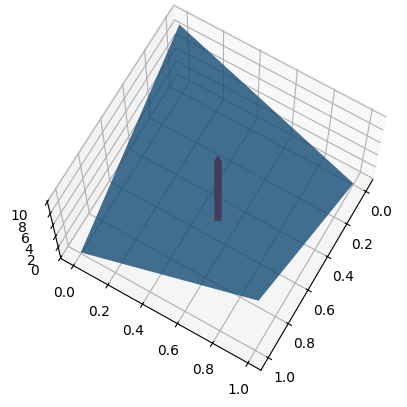

(array([0.5, 0.5]), 20)

In [15]:
F_obs = [
    [10, 0],
    [0, 10]
    ]

#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data
mass = 10
x = np.array([[0, 0], [1, 1]])
y = np.array([[0, 1], [0, 1]])
z = np.array([[F_obs[0][0], F_obs[0][1]], [F_obs[1][0], F_obs[1][1]]])

# Plot the surface
ax.set_zlim(0, mass)
surf = ax.plot_surface(x, y, z, alpha=0.8)

# Plot the point of mass
pt, mass = fourpanel_evaluate(F_obs)

count = 100
xp = np.array([pt[0]] * count)
yp = np.array([pt[1]] * count)
zp = np.linspace(0, mass / 2, count)
ax.scatter(xp, yp, zp, c='#ff0000', marker='^')

# move the angle
ax.view_init(elev=70, azim=30, roll=0)

plt.show()
pt, mass

In [26]:

THRES = 0.0001

def thirtysixpanel_evaluate(F_obs: np.ndarray):
    # expects 6x6 array F_obs
    assert F_obs.shape == (6, 6)

    F_net = np.sum(F_obs)

    F_obs_scaled = F_obs / F_net

    # use center of mass as initial guess
    x_sum = 0
    y_sum = 0
    for i in range(6):
        for j in range(6):
            x_sum += j * F_obs_scaled[i][j]
        y_sum += i * np.sum(F_obs_scaled[i])
    initial_guess = [x_sum, y_sum]

    #define error function (sum of squared error)
    def error_function(vars):
        x, y, = vars

        F_pred = np.zeros((6, 6))
        for i in range(6):
            for j in range(6):
                dist = np.sqrt((x-j)**2 + (y-i)**2)

                if dist > 3:
                    F_pred[i][j] = 0
                elif dist == 0:
                    F_pred[i][j] = 2**31-1
                else:
                    F_pred[i][j] = 1 / dist
        
        F_pred_net = np.sum(F_pred)
        F_pred_scaled = F_pred / F_pred_net

        # print(F_pred_scaled)

        error = 0
        for i in range(6):
            for j in range(6):
                err_term = (F_obs_scaled[i][j] - F_pred_scaled[i][j])**2
                if err_term >= THRES:
                    error += err_term
        
        # print(error)
        # print()
        return error
    
    result = minimize(error_function, initial_guess, bounds=[(0.0001, 4.9999), (0.0001, 4.9999)],
                      method='L-BFGS-B')
    print(result)
    return result.x, F_net

F_obs = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 2],
    [0, 0, 0, 0, 5, 4],
    [0, 0, 0, 0, 6, 2],
    [0, 0, 0, 0, 0, 0]
    ])
thirtysixpanel_evaluate(F_obs)



  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 0.06930332682962838
        x: [ 4.395e+00  3.193e+00]
      nit: 6
      jac: [ 5.292e-03 -2.228e-03]
     nfev: 249
     njev: 83
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


(array([4.39508893, 3.19346953]), 23)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.02703653917352613
        x: [ 1.268e+00  1.883e+00]
      nit: 7
      jac: [ 4.904e-06 -6.184e-06]
     nfev: 39
     njev: 13
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


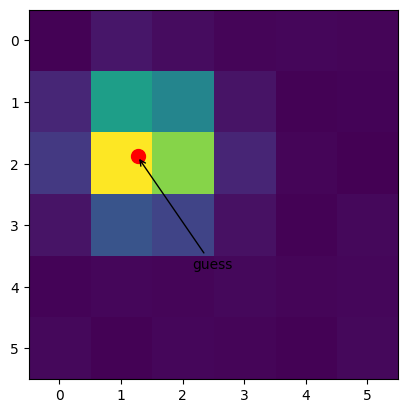

In [25]:
def gen_test_array(x, y, k, rk):
    # generate equation for e^(-r^k) with some random noise with magnitude rk
    noise_array = np.random.random((6, 6)) * rk
    value_array = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            dx = x - j
            dy = y - i
            r = (dx**2 + dy**2)**0.5
            value_array[i][j] = np.exp(-(r**k))
    return value_array + noise_array

arr = gen_test_array(1.4, 1.8, 2, 0.02)

plt.figure()
plt.imshow(arr)

pt, mass = thirtysixpanel_evaluate(arr)
x, y = pt

plt.annotate('guess', xy=(x, y), xycoords='data',
             xytext=(0.3, 0.3), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
plt.scatter(x, y, s=100, c='red', marker='o')
plt.show()